(1, 28, 28)
[5]


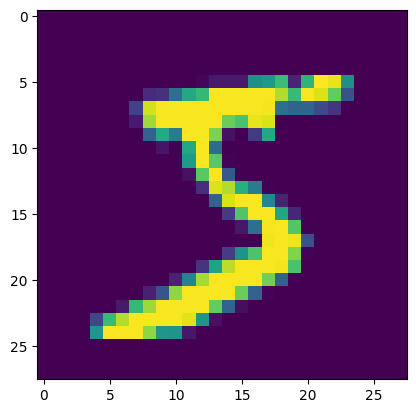

In [1]:
import numpy as np, sys
import matplotlib.pyplot as plt
np.random.seed(1)

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train[:1].shape)
print(y_train[:1])
plt.imshow(x_train[0])

In [2]:
images, labels = (x_train[0:1000].reshape(1000, 28*28)/255, y_train[0:1000])
one_hot_labels = np.zeros((len(labels), 10))

print(one_hot_labels.shape)

for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1

labels = one_hot_labels

(1000, 10)


In [3]:
test_images = x_test.reshape(len(x_test), 28*28) / 255
test_labels = np.zeros((len(y_test), 10))

for i, l in enumerate(y_test):
    test_labels[i][l] = 1


print(test_images.shape)
print(test_labels.shape)

(10000, 784)
(10000, 10)


In [4]:
def tanh(x):
    return np.tanh(x)

def tanh2deriv(output):
    return 1 - (output ** 2)

def softmax(x):
    temp = np.exp(x)
    return temp / np.sum(temp, axis=1, keepdims=True)

In [5]:
alpha, iterations = (2, 300)
pixels_per_image, num_labels = (784, 10)
batch_size = 128

input_rows = 28
input_cols = 28

kernel_rows = 3
kernel_cols = 3
num_kernels = 16

hidden_size = ((input_rows - kernel_rows) * (input_cols - kernel_cols)) * num_kernels
kernels = 0.02 * np.random.random((kernel_rows*kernel_cols, num_kernels)) - 0.01
weight_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

In [6]:
def get_image_section(layer, row_from, row_to, col_from, col_to):
    section = layer[:, row_from:row_to, col_from:col_to]
    return section.reshape(-1, 1, row_to - row_from, col_to - col_from)

In [7]:
for j in range(iterations):
    correct_cnt = 0
    for i in range(int(len(images) / batch_size)):
        batch_start, batch_end = ((i * batch_size), ((i+1)*batch_size))

        layer_0 = images[batch_start:batch_end]
        layer_0 = layer_0.reshape(layer_0.shape[0], 28, 28)
        layer_0.shape

        sects = list()
        for row_start in range(layer_0.shape[1] - kernel_rows):
            for col_start in range(layer_0.shape[2] - kernel_cols):
                sect = get_image_section(layer_0, row_start, row_start+kernel_rows, col_start, col_start+kernel_cols)
                sects.append(sect)

        expanded_input = np.concatenate(sects, axis=1)
        es = expanded_input.shape
        flattened_input = expanded_input.reshape(es[0]*es[1], -1)

        kernel_output = flattened_input.dot(kernels)
        layer_1 = tanh(kernel_output.reshape(es[0], -1))
        dropout_mask = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask * 2
        layer_2 = softmax(np.dot(layer_1, weight_1_2))

        for k in range(batch_size):
            labelset = labels[batch_start+k:batch_start+k+1]
            _inc = int(np.argmax(layer_2[k:k+1]) == np.argmax(labelset))
            correct_cnt += _inc

        layer_2_delta = (labels[batch_start: batch_end] - layer_2) / (batch_size * layer_2.shape[0])
        layer_1_delta = layer_2_delta.dot(weight_1_2.T)* tanh2deriv(layer_1)
        layer_1_delta *= dropout_mask

        weight_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        l1d_reshape = layer_1_delta.reshape(kernel_output.shape)
        k_update = flattened_input.T.dot(l1d_reshape)
        kernels -= alpha * k_update

    test_correct_cnt = 0
    for i in range(len(test_images)):
        layer_0 = test_images[i:i+1]
        layer_0 = layer_0.reshape(layer_0.shape[0], 28, 28)
        layer_0.shape

        sects = list()
        for row_start in range(layer_0.shape[1] - kernel_rows):
            for cols_start in range(layer_0.shape[2] - kernel_cols):
                sect = get_image_section(layer_0, row_start, row_start+kernel_rows, col_start, col_start+kernel_cols)
                sects.append(sect)

        expanded_input = np.concatenate(sects, axis=1)
        es = expanded_input.shape
        flattened_input = expanded_input.reshape(es[0]*es[1], -1)

        kernel_output = flattened_input.dot(kernels)
        layer_1 = tanh(kernel_output.reshape(es[0], -1))
        layer_2 = np.dot(layer_1, weight_1_2)

        test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))

    if(j%1 == 0):
        sys.stdout.write("\n"+ \
                         " I: "+str(j) + \
                         " Test-Acc: "+ str(test_correct_cnt/float(len(test_images))) + \
                         " Train-Acc: "+ str(correct_cnt/float(len(images))))





 I: 0 Test-Acc: 0.0787 Train-Acc: 0.055
 I: 1 Test-Acc: 0.08 Train-Acc: 0.037
 I: 2 Test-Acc: 0.0808 Train-Acc: 0.037
 I: 3 Test-Acc: 0.0814 Train-Acc: 0.04
 I: 4 Test-Acc: 0.0817 Train-Acc: 0.046
 I: 5 Test-Acc: 0.0822 Train-Acc: 0.068
 I: 6 Test-Acc: 0.0832 Train-Acc: 0.083
 I: 7 Test-Acc: 0.087 Train-Acc: 0.096
 I: 8 Test-Acc: 0.0886 Train-Acc: 0.127
 I: 9 Test-Acc: 0.0952 Train-Acc: 0.148
 I: 10 Test-Acc: 0.0987 Train-Acc: 0.181
 I: 11 Test-Acc: 0.1001 Train-Acc: 0.209
 I: 12 Test-Acc: 0.1015 Train-Acc: 0.238
 I: 13 Test-Acc: 0.1038 Train-Acc: 0.286

KeyboardInterrupt: 